In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()
plt.rcParams.update({'figure.facecolor':'white'})

# Load data and do basic formatting

In [2]:
df = pd.read_csv("../data/processed_sensor_dwd.csv", index_col=0)

In [3]:
# convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# convert pressure to hPa
df['pressure_sensors'] = df['pressure_sensors'] / 100
df['pressure_std'] = df['pressure_std'] / 100

# add sensor IDs
df_location = df.groupby(['lat', 'lon']).count().reset_index()[['lat', 'lon']]
df_location['location_id'] = df_location.index+1
df = df.merge(df_location, on=['lat', 'lon'], how='left')

# define lists with columns
no_data_cols = ['location_id', 'timestamp', 'city', 'lat', 'lon']
sc_cols = sorted(['PM10', 'PM2p5', 'PM10_std', 'PM2p5_std', 'pressure_sensors', 'temperature_sensors', 'humidity_sensors', 'pressure_std', 'temperature_std', 'humidity_std'])
sc_cols_wo_std = [col for col in sc_cols if 'std' not in col]
dwd_cols = sorted([col for col in df.columns if (col not in no_data_cols and col not in sc_cols)])
std_cols = [col for col in sc_cols if 'std' in col]
data_cols_wo_std = sc_cols_wo_std + dwd_cols
data_cols = sc_cols + dwd_cols

# reorganize columns: first non-data columns, then sorted data columns
df = df.reindex(columns=no_data_cols + sc_cols + dwd_cols)
df

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,humidity_sensors,...,temperature_sensors,temperature_std,WRTR,humidity_dwd,precip,pressure_dwd,pressure_sealevel,temperature_dwd,wind_direction,wind_speed
0,2,2020-01-01 00:00:00,Frankfurt,50.042000,8.436000,212.110833,24.278724,140.574167,16.827501,96.000000,...,2.700000,NaN,NaN,90.0,0.0,1023.1,1036.5,0.0,40.0,2.7
1,2,2020-01-01 01:00:00,Frankfurt,50.042000,8.436000,196.873043,24.933247,129.469130,16.857172,96.100000,...,2.400000,NaN,0.0,90.0,0.0,1022.9,1036.3,0.1,20.0,2.8
2,2,2020-01-01 02:00:00,Frankfurt,50.042000,8.436000,188.258182,36.770146,124.460455,26.337616,96.633333,...,2.133333,0.057735,0.0,92.0,0.0,1022.8,1036.2,-1.1,70.0,2.2
3,2,2020-01-01 03:00:00,Frankfurt,50.042000,8.436000,166.444500,30.844667,105.790000,21.422815,97.600000,...,1.850000,0.057735,NaN,93.0,0.0,1022.3,1035.7,-0.4,80.0,1.6
4,2,2020-01-01 04:00:00,Frankfurt,50.042000,8.436000,101.033600,18.991551,62.073600,12.735376,97.550000,...,1.650000,0.212132,0.0,90.0,0.0,1022.1,1035.4,0.2,50.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450715,86,2022-02-28 19:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,46.0,0.0,1018.3,1031.4,5.3,80.0,1.3
3450716,86,2022-02-28 20:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,59.0,0.0,1018.5,1031.7,2.0,90.0,1.0
3450717,86,2022-02-28 21:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,61.0,0.0,1018.5,1031.7,1.8,50.0,2.0
3450718,86,2022-02-28 22:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,61.0,0.0,1018.3,1031.5,2.0,60.0,1.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3450720 entries, 0 to 3450719
Data columns (total 23 columns):
 #   Column               Dtype         
---  ------               -----         
 0   location_id          int64         
 1   timestamp            datetime64[ns]
 2   city                 object        
 3   lat                  float64       
 4   lon                  float64       
 5   PM10                 float64       
 6   PM10_std             float64       
 7   PM2p5                float64       
 8   PM2p5_std            float64       
 9   humidity_sensors     float64       
 10  humidity_std         float64       
 11  pressure_sensors     float64       
 12  pressure_std         float64       
 13  temperature_sensors  float64       
 14  temperature_std      float64       
 15  WRTR                 float64       
 16  humidity_dwd         float64       
 17  precip               float64       
 18  pressure_dwd         float64       
 19  pressure_sealevel    

# Investigation of missing values, zeros and outliers

In [5]:
# Basic statistics of the whole sc dataset
df[sc_cols_wo_std].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
PM10,1872408.0,28.1,162.7,0.0,4.2,8.1,16.1,1999.9
PM2p5,1872405.0,15.0,84.5,0.0,1.9,4.1,9.2,999.9
humidity_sensors,1559298.0,79.8,26.9,0.0,63.2,95.5,99.9,2094.5
pressure_sensors,366039.0,997.3,170.8,9.5,998.7,1006.4,1014.6,64373.9
temperature_sensors,1571687.0,12.2,53.9,-3276.6,6.8,12.2,19.1,196.0


In [6]:
# Basic statistics of the sc dataset for Frankfurt
df[df['city']=='Frankfurt'][sc_cols_wo_std].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
PM10,1230735.0,19.1,106.0,0.0,3.7,7.1,13.9,1999.9
PM2p5,1230733.0,11.0,60.1,0.0,1.7,3.7,8.2,999.9
humidity_sensors,1004738.0,76.4,28.8,0.0,58.1,89.5,99.9,2094.5
pressure_sensors,269766.0,999.1,185.7,9.5,997.3,1004.2,1010.8,64373.9
temperature_sensors,1015272.0,11.8,66.7,-3276.6,6.7,12.2,19.4,196.0


In [7]:
# Basic statistics of the sc dataset for Bremen
df[df['city']=='Bremen'][sc_cols_wo_std].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
PM10,641673.0,45.3,235.1,0.0,5.6,10.6,20.8,1999.9
PM2p5,641672.0,22.7,117.6,0.0,2.4,4.9,11.5,999.9
humidity_sensors,554560.0,85.9,21.7,0.0,75.7,99.9,99.9,100.0
pressure_sensors,96273.0,992.5,119.2,9.8,1006.6,1015.1,1021.8,1118.6
temperature_sensors,556415.0,13.0,9.6,-145.2,7.0,12.2,18.6,64.9


PM10: Mean is almost double of the 75th percentile -> Outliers raise the mean extremely </br>
PM2.5: similar to PM10, but less extreme </br>
humidity: al values (mean, 25th, 50th and 75th percentile) seem to be very large, the max value is above 100, what doesn't make any sense </br>
pressure: assuming the units are Pa (1 bar = 100.000 Pa): min value is below 100 -> unrealistic, max value is also unrealistic (more than 60 bar) </br>
temperature: std seems very high (54 °C), min and max value are unrealistic </br>
 </br>
 Bremen vs. Frankfurt </br>
 PM10 and PM2.5: std for Bremen is double of std for Frankfurt </br>
 humidity: 50th percentile of Bremen is already 99.9 % what seems quite high
 pressure and temperature: no obvious unrealistic observations besides the min and max values

In [8]:
print("missing values in each column")
for col in df.columns:
    print(f"{col}: {df[col].isna().sum()} ({round(df[col].isna().sum() / df.shape[0] * 100, 1)} %)")

missing values in each column
location_id: 0 (0.0 %)
timestamp: 0 (0.0 %)
city: 0 (0.0 %)
lat: 0 (0.0 %)
lon: 0 (0.0 %)
PM10: 1578312 (45.7 %)
PM10_std: 1584241 (45.9 %)
PM2p5: 1578315 (45.7 %)
PM2p5_std: 1584245 (45.9 %)
humidity_sensors: 1891422 (54.8 %)
humidity_std: 1896014 (54.9 %)
pressure_sensors: 3084681 (89.4 %)
pressure_std: 3085662 (89.4 %)
temperature_sensors: 1879033 (54.5 %)
temperature_std: 1883631 (54.6 %)
WRTR: 1151192 (33.4 %)
humidity_dwd: 174 (0.0 %)
precip: 17702 (0.5 %)
pressure_dwd: 0 (0.0 %)
pressure_sealevel: 174 (0.0 %)
temperature_dwd: 174 (0.0 %)
wind_direction: 116 (0.0 %)
wind_speed: 17906 (0.5 %)


In [9]:
print("value '0' in each column")
for col in df.columns:
    print(f"{col}: {df[df[col]==0][col].count()} ({round(df[df[col]==0][col].count() / df.shape[0] * 100, 1)} %)")

value '0' in each column
location_id: 0 (0.0 %)
timestamp: 0 (0.0 %)
city: 0 (0.0 %)
lat: 0 (0.0 %)
lon: 0 (0.0 %)
PM10: 2662 (0.1 %)
PM10_std: 15968 (0.5 %)
PM2p5: 3300 (0.1 %)
PM2p5_std: 22337 (0.6 %)
humidity_sensors: 303 (0.0 %)
humidity_std: 746411 (21.6 %)
pressure_sensors: 0 (0.0 %)
pressure_std: 973 (0.0 %)
temperature_sensors: 201 (0.0 %)
temperature_std: 16345 (0.5 %)
WRTR: 1745498 (50.6 %)
humidity_dwd: 0 (0.0 %)
precip: 3113294 (90.2 %)
pressure_dwd: 0 (0.0 %)
pressure_sealevel: 0 (0.0 %)
temperature_dwd: 6906 (0.2 %)
wind_direction: 480 (0.0 %)
wind_speed: 0 (0.0 %)


In [10]:
def count_nan_and_0s(df: pd.DataFrame, cols: list = None) -> pd.DataFrame:
    """Counts zeros and nans per column.

    Args:
        df (pd.DataFrame): Dataframe to search for zeros and nans.
        cols (list, optional): List of columns, if no columns are specified all will be used. Defaults to None.
        thresholds (dict, optional): Thresholds for further . Defaults to None.

    Returns:
        pd.DataFrame: Dataframe containing counts of zeros and nans.
    """
    # use all columns af none were defined
    if cols == None:
        cols=df.columns
    # make a new dataframe and put the defined column names in the first column
    df_nan_0 = pd.DataFrame()
    df_nan_0['data'] = cols
    # calculate missing values and zeros as absolute value and share 
    df_nan_0['missing_values'] = [df[col].isna().sum() for col in cols]
    df_nan_0['missing_values_share'] = [df[col].isna().sum() / df.shape[0] * 100 for col in cols]
    df_nan_0['0_values'] = [df[df[col]==0][col].count() for col in cols]
    df_nan_0['0_values_share'] = [df[df[col]==0][col].count() / df.shape[0] * 100 for col in cols]

    # transpose the dataframe and use the original column names as column names
    df_nan_0 = df_nan_0.set_index('data').T.reset_index()
    df_nan_0.columns = [name if i>0 else 'metric' for i, name in enumerate(df_nan_0.columns)]
    return df_nan_0


# find missing values and zeros in the sc dataset
df_data_analysis = count_nan_and_0s(df, data_cols)
df_data_analysis.round(1)

,metric,PM10,PM10_std,PM2p5,PM2p5_std,humidity_sensors,humidity_std,pressure_sensors,pressure_std,temperature_sensors,temperature_std,WRTR,humidity_dwd,precip,pressure_dwd,pressure_sealevel,temperature_dwd,wind_direction,wind_speed
0,missing_values,1578312.0,1584241.0,1578315.0,1584245.0,1891422.0,1896014.0,3084681.0,3085662.0,1879033.0,1883631.0,1151192.0,174.0,17702.0,0.0,174.0,174.0,116.0,17906.0
1,missing_values_share,45.7,45.9,45.7,45.9,54.8,54.9,89.4,89.4,54.5,54.6,33.4,0.0,0.5,0.0,0.0,0.0,0.0,0.5
2,0_values,2662.0,15968.0,3300.0,22337.0,303.0,746411.0,0.0,973.0,201.0,16345.0,1745498.0,0.0,3113294.0,0.0,0.0,6906.0,480.0,0.0
3,0_values_share,0.1,0.5,0.1,0.6,0.0,21.6,0.0,0.0,0.0,0.5,50.6,0.0,90.2,0.0,0.0,0.2,0.0,0.0


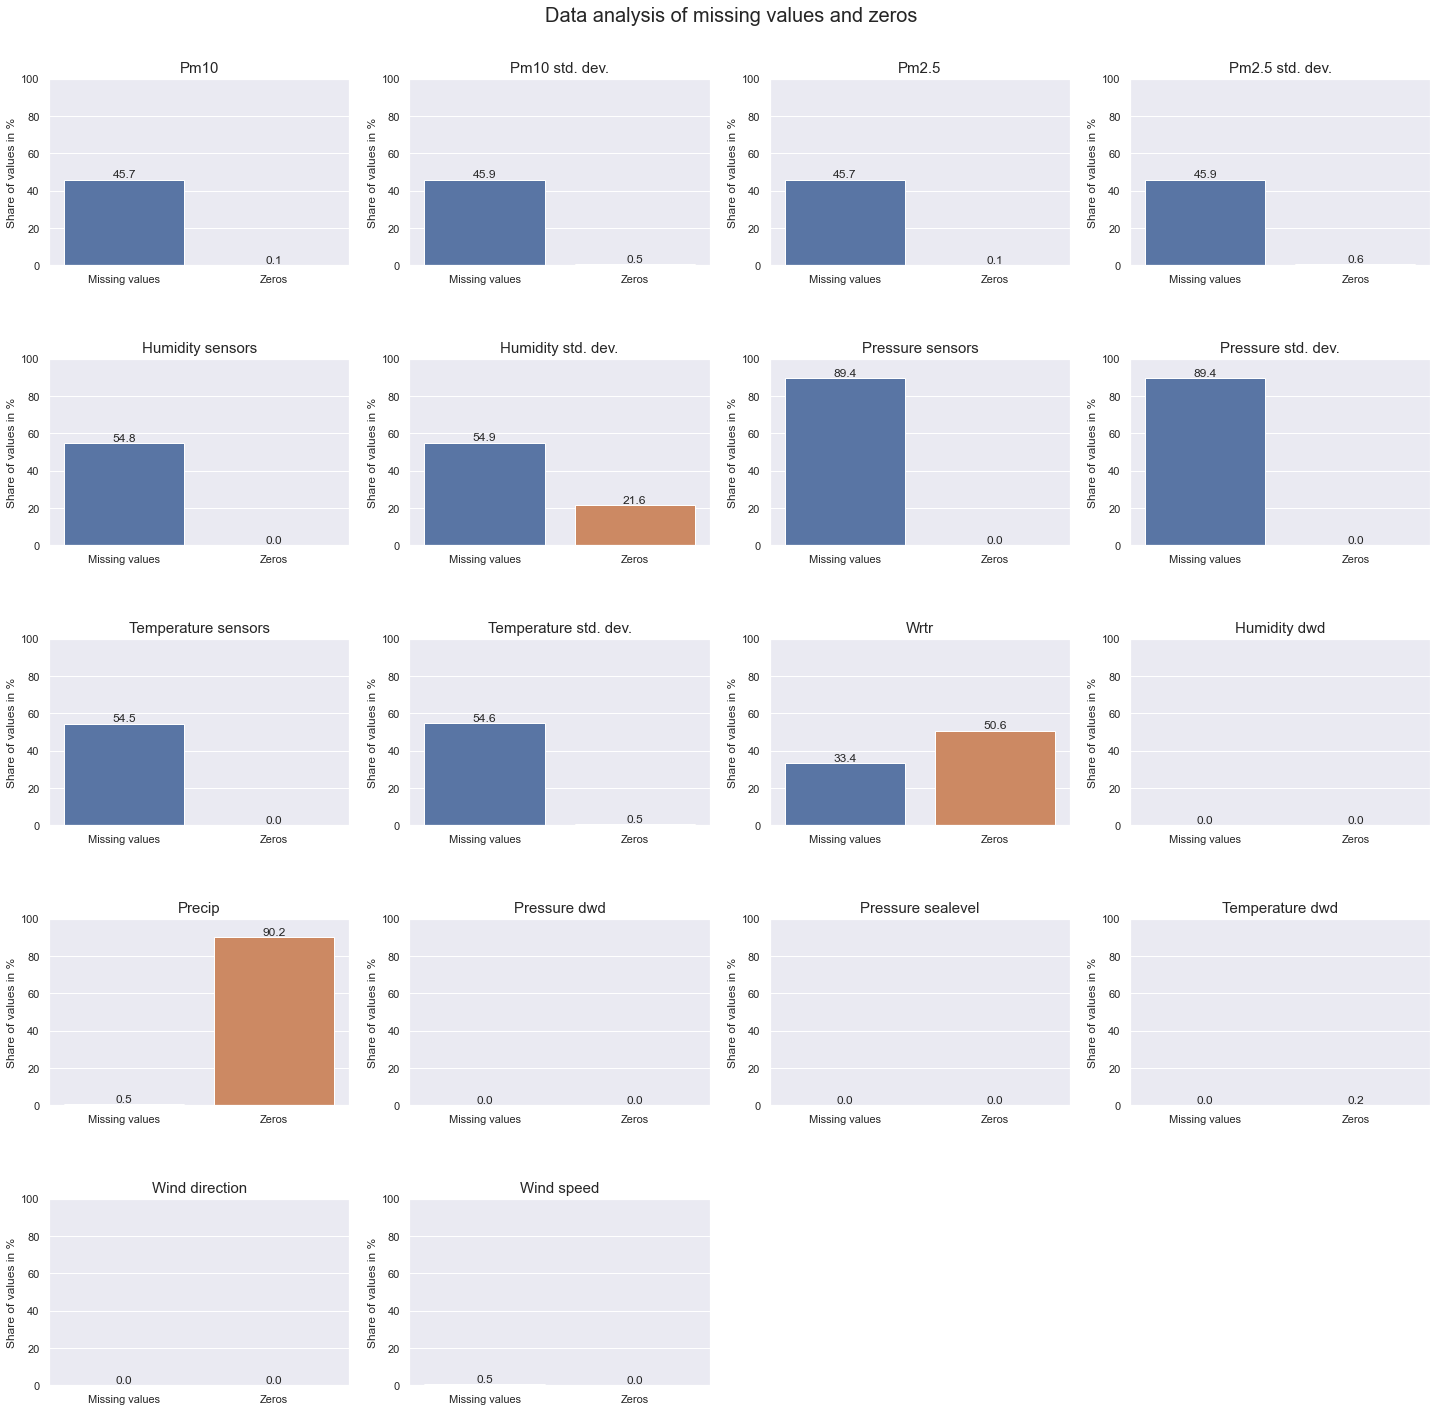

In [11]:
# define metrics and columns to plot
metrics = ["missing_values_share", "0_values_share"]
ys = list(df_data_analysis.columns)
ys.remove('metric')

# define size of subplot
columns = 4
rows = int(np.ceil((len(df_data_analysis.columns) - 1) / columns))

# plot
fig, ax = plt.subplots(rows, columns, figsize=(20,20)) # create subplots
plt.suptitle("Data analysis of missing values and zeros", fontsize=20) # title of plot
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .93) # adjusts the space between the single subplots

for row in range(rows):
    for col in range(columns):
        if col + row * columns < len(ys):
        
            # create a bar for each metric defined above for a column of ys list
            sns.barplot(data=df_data_analysis[df_data_analysis['metric'].isin(metrics)], x='metric', y=ys[col + row * columns], ax=ax[row][col])
            # set ylim to [0, 100] as we are plotting percentages
            ax[row][col].set_ylim([0, 100])
            # put the percentage above each plotted bar
            ax[row][col].bar_label(ax[row][col].containers[0], fmt='%.1f')
            # set the x, y and x-tick labels
            ax[row][col].set_xlabel("")
            ax[row][col].set_ylabel("Share of values in %")
            ax[row][col].set_xticklabels(labels=["Missing values", "Zeros"])
            # use the column name with slight changes as subplot name
            title = f"{ys[col + row * columns]}".replace('_', ' ').replace('std', 'std. dev.').replace('2p5', '2.5').capitalize()
            ax[row][col].set_title(title, fontsize = 15);
        else:
            # delete not needed subplots
            fig.delaxes(ax[row][col])


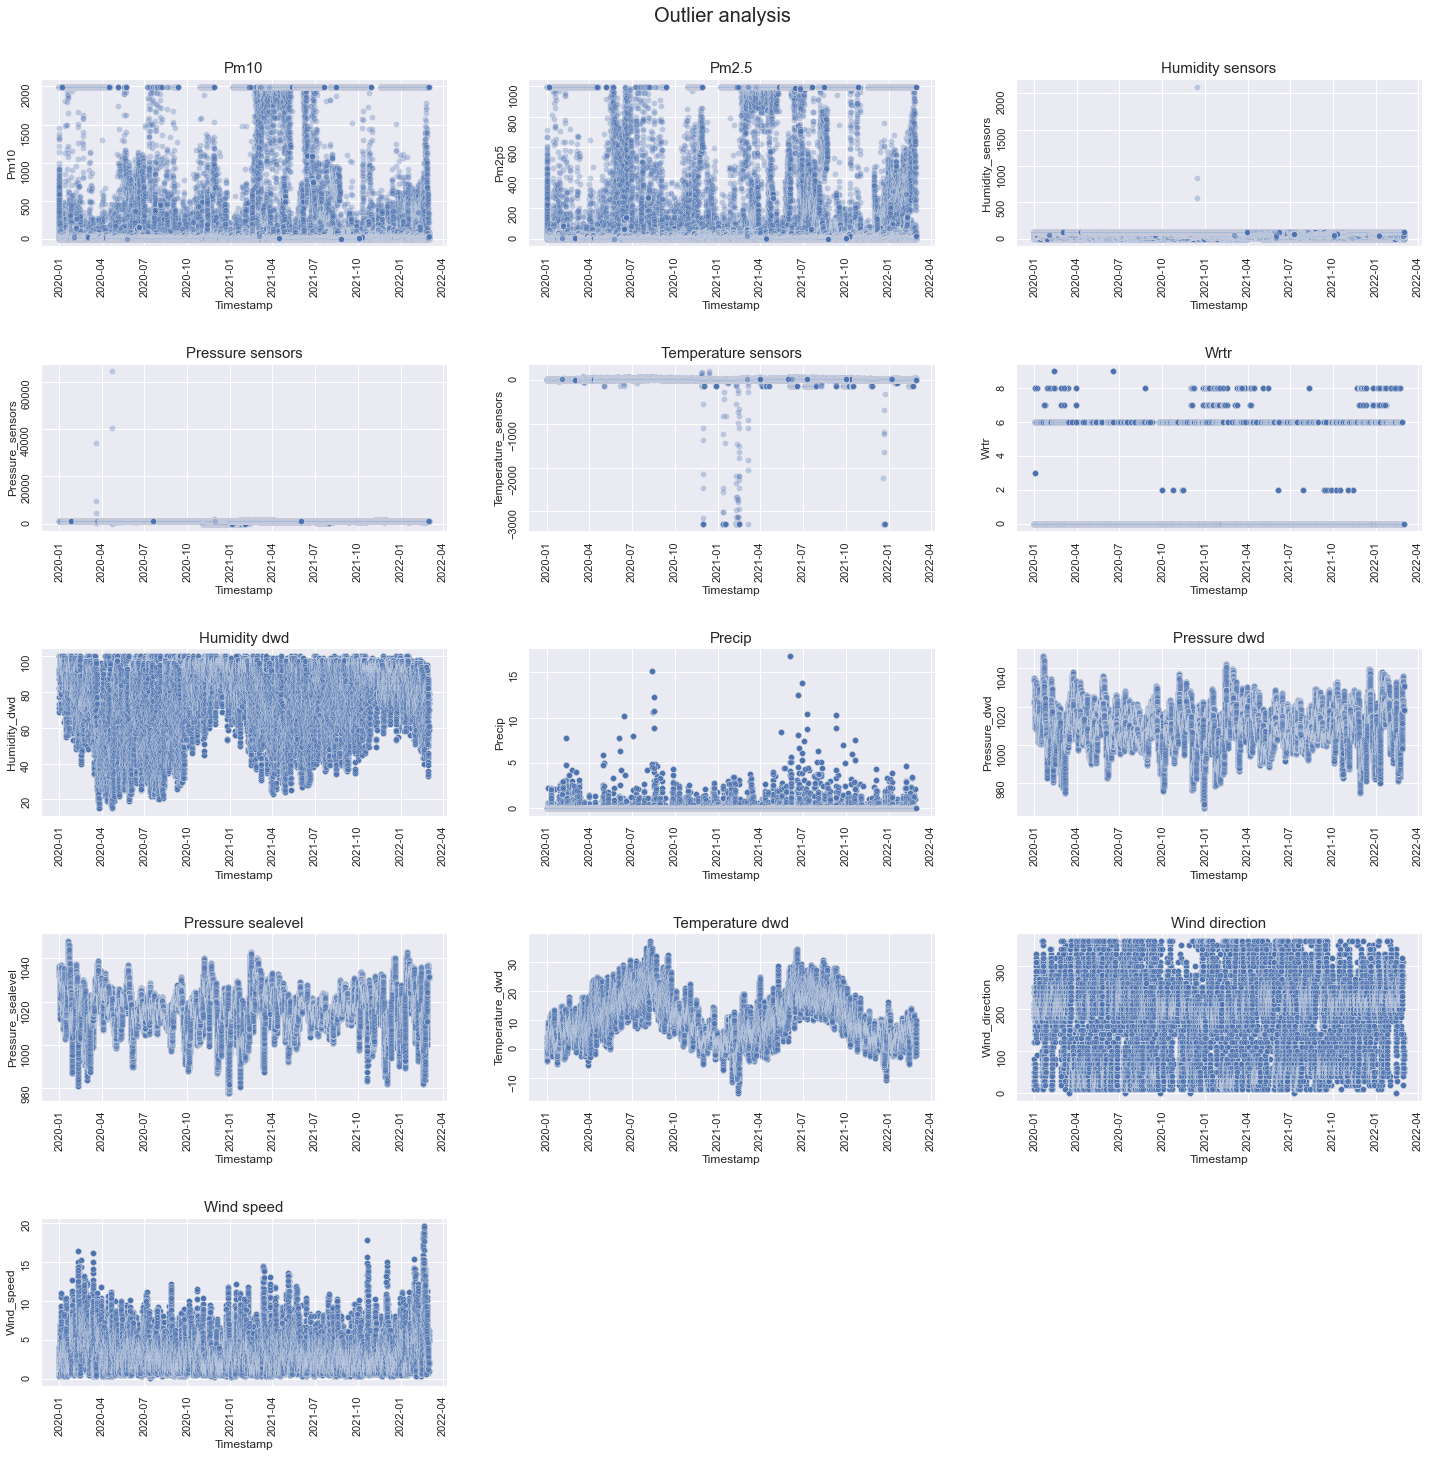

In [12]:
# columns to plot
ys = data_cols_wo_std

# define size of subplot
columns = 3
rows = int(np.ceil((len(ys)) / columns))

# plot
fig, ax = plt.subplots(rows, columns, figsize=(20,20)) # create subplots
plt.suptitle("Outlier analysis", fontsize=20) # title of plot
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .7, wspace = .2, top = .93) # adjusts the space between the single subplots

for row in range(rows):
    for col in range(columns):
        if col + row * columns < len(ys):

            # create a bar for each metric defined above for a column of ys list
            sns.scatterplot(data=df, x='timestamp', y=ys[col + row * columns], ax=ax[row][col], alpha=.3)
            # set the x, y and x-tick labels
            ax[row][col].set_xlabel(ax[row][col].get_xlabel().capitalize())
            ax[row][col].set_ylabel(ax[row][col].get_ylabel().capitalize())
            # use the column name with slight changes as subplot name
            title = f"{ys[col + row * columns]}".replace('_', ' ').replace('std', 'std. dev.').replace('2p5', '2.5').capitalize()
            ax[row][col].set_title(title, fontsize = 15)
            ax[row][col].tick_params(labelrotation=90)
        else:
            # delete not needed subplots
            fig.delaxes(ax[row][col])


There are few outliers in humidity, pressure and temperature which can be dropped by setting thresholds. </br>
For PM10 and PM2.5 it is less obvious as the data is scattered all over the possible range. 

# Delete unrealistic values and outliers for environmental variables

## hard thresholds based on physical estimations
We can first have a look at the extreme values measured by Deutscher Wetterdienst to get an impression what range of values is realistic.

In [13]:
print(df['humidity_dwd'].max())
print(df.query("city == 'Frankfurt'")['humidity_dwd'].min())
print(df.query("city == 'Bremen'")['humidity_dwd'].min())

100.0
15.0
22.0


In [14]:
print(df['pressure_dwd'].max())
print(df.query("city == 'Frankfurt'")['pressure_dwd'].min())
print(df.query("city == 'Bremen'")['pressure_dwd'].min())

1046.4
967.0
977.1


In [15]:
print(df['temperature_dwd'].max())
print(df.query("city == 'Frankfurt'")['temperature_dwd'].min())
print(df.query("city == 'Bremen'")['temperature_dwd'].min())

37.1
-10.5
-15.4


In [16]:
# thresholds_part = {
#     'PM10': (0, 1000),
#     'PM2p5': (0, 500),
# }
# set lower and upper threshold
thresholds_env = {
    'humidity_sensors': (15, 100),
    'pressure_sensors': (960, 1050),
    'temperature_sensors': (-20, 60),
}

# delete values below lower and above upper threshold
for col, thresh in thresholds_env.items():
    nan_before = df[col].isna().sum()
    df.iloc[df[col] <= thresh[0], list(df.columns).index(col)] = np.nan
    df.iloc[df[col] >= thresh[1], list(df.columns).index(col)] = np.nan
    print(f"added {df[col].isna().sum() - nan_before} nans in {col}")


added 117193 nans in humidity_sensors
added 9638 nans in pressure_sensors
added 2133 nans in temperature_sensors


## values with std. dev. 'nan' or zero
If the standard deviation is 'nan', there was no or only one observation. If the standard deviation is zero, there was no fluctuation in the measured value, what can be assumed to be a measurement error.

In [17]:
# delete values for the defined columns if the standard deviation is zero or 'nan'
for col in [
    'temperature_sensors',
    'humidity_sensors',
    'pressure_sensors',
]:
    nan_before = df[col].isna().sum()
    df.loc[df[col.split('_')[0]+'_std']==0, col] = np.nan    
    df.loc[df[col.split('_')[0]+'_std']==np.nan, col] = np.nan    
    print(f"added {df[col].isna().sum() - nan_before} nans in {col}")


added 14843 nans in temperature_sensors
added 637325 nans in humidity_sensors
added 49 nans in pressure_sensors


## dynamic thresholds based on quantiles

In [18]:
# define quantiles as threshold
thresh = {
    'temperature': (.01, .85),
    'humidity': (.05, .95),
    'pressure': (.05, .95),
}

# make a dataframe containing median, upper and lower threshold defined by the quantiles above
df_thresholds = df.groupby(['city', 'timestamp']).agg(
    temp_median = pd.NamedAgg(column='temperature_sensors', aggfunc='median'), 
    temp_lower = pd.NamedAgg(column='temperature_sensors', aggfunc=lambda x: x.quantile(q=thresh['temperature'][0])),
    temp_upper = pd.NamedAgg(column='temperature_sensors', aggfunc=lambda x: x.quantile(q=thresh['temperature'][1])),
    hum_median = pd.NamedAgg(column='humidity_sensors', aggfunc='median'), 
    hum_lower = pd.NamedAgg(column='humidity_sensors', aggfunc=lambda x: x.quantile(q=thresh['humidity'][0])),
    hum_upper = pd.NamedAgg(column='humidity_sensors', aggfunc=lambda x: x.quantile(q=thresh['humidity'][1])),
    pres_median = pd.NamedAgg(column='pressure_sensors', aggfunc='median'), 
    pres_lower = pd.NamedAgg(column='pressure_sensors', aggfunc=lambda x: x.quantile(q=thresh['pressure'][0])),
    pres_upper = pd.NamedAgg(column='pressure_sensors', aggfunc=lambda x: x.quantile(q=thresh['pressure'][1])),
).reset_index()

# merge the thresholds with the sc dataframe
df = df.merge(df_thresholds, how='left', on=['city', 'timestamp'])

In [19]:
df_thresholds.columns

Index(['city', 'timestamp', 'temp_median', 'temp_lower', 'temp_upper',
       'hum_median', 'hum_lower', 'hum_upper', 'pres_median', 'pres_lower',
       'pres_upper'],
      dtype='object')

In [20]:
# replace values below lower threshold and above upper threshold with 'nan'
for col, thresholds in {
    'temperature_sensors': ['temp_lower', 'temp_upper'],
    'humidity_sensors': ['hum_lower', 'hum_upper'],
    'pressure_sensors': ['pres_lower','pres_upper'],
}.items():
    nan_before = df[col].isna().sum()
    df.loc[(df[col] < df[thresholds[0]]) | (df[col] > df[thresholds[1]]), col] = np.nan
    print(f"{df[col].isna().sum() - nan_before} nans added in {col}")


282580 nans added in temperature_sensors
112751 nans added in humidity_sensors
72212 nans added in pressure_sensors


In [21]:
# drop columns used for dynamic thresholding
df.drop([col for col in df_thresholds.columns if not col in no_data_cols], axis=1, inplace=True)

# Visualization of cleaned data and comparison with dwd data

In [22]:
def plot_sc_vs_dwd(city, columns=1, reduction=1):
    # Plot dwd and sc data 
    # define size of subplot
    rows = int(np.ceil(3 / columns))

    fig, ax = plt.subplots(rows, columns, figsize=(20,20)) # create subplots
    plt.suptitle(f"Comparison sensor data vs. dwd in {city}", fontsize=20) # title of plot
    fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
    plt.subplots_adjust(hspace = .2, wspace = .2, top = .95) # adjusts the space between the single subplots

    # Plot humidity from both datasets vs time
    sns.scatterplot(data=df[(df['humidity_sensors'].notna()) & (df['city'] == city)][::reduction], x='timestamp', y='humidity_sensors', ax=ax[0], label='Sensor Community')
    sns.lineplot(data=df[(df['humidity_dwd'].notna()) & (df['city']== city)], x='timestamp', y='humidity_dwd', color='red', alpha=.5, ax=ax[0], label='Deutscher Wetterdienst')
    ax[0].set_ylabel('Relative Humidity in %')

    # Plot pressure from both datasets vs time
    sns.scatterplot(data=df[(df['pressure_sensors'].notna()) & (df['city'] == city)][::reduction], x='timestamp', y='pressure_sensors', ax=ax[1], label='Sensor Community')
    sns.lineplot(data=df[(df['pressure_dwd'].notna()) & (df['city']== city)], x='timestamp', y='pressure_dwd', color='red', alpha=.5, ax=ax[1], label='Deutscher Wetterdienst')
    ax[1].set_ylabel('Pressure in hPa')

    # Plot temperature from both datasets vs time
    sns.scatterplot(data=df[(df['temperature_sensors'].notna()) & (df['city'] == city)][::reduction], x='timestamp', y='temperature_sensors', ax=ax[2], label='Sensor Community')
    sns.lineplot(data=df[(df['temperature_dwd'].notna()) & (df['city']== city)], x='timestamp', y='temperature_dwd', color='red', alpha=.5, ax=ax[2], label='Deutscher Wetterdienst')
    ax[2].set_ylabel('Temperature in °C')

    xlim_left = df['timestamp'].min()
    xlim_right = df['timestamp'].max()

    # capitalize axis titles and add legend
    for i in range(3):
        ax[i].legend(loc='lower right')
        ax[i].set_xlabel(ax[i].get_xlabel().capitalize())
        ax[i].set_xlim(xlim_left, xlim_right)
    
    


In [23]:
# # Plot comparison of data from both sources for Frankfurt
# plot_sc_vs_dwd('Frankfurt')
# plt.savefig("../figures/EDA_sc_vs_dwd_Frankfurt.png", bbox_inches='tight')
# plt.close()
# ;

![EDA_sc_vs_dwd_Frankfurt.png](../figures/EDA_sc_vs_dwd_Frankfurt.png)


In [24]:
# # Plot comparison of data from both sources for Bremen
# plot_sc_vs_dwd('Bremen')
# plt.savefig("../figures/EDA_sc_vs_dwd_Bremen.png", bbox_inches='tight')
# plt.close()
# ;

![EDA_sc_vs_dwd_Bremen.png](../figures/EDA_sc_vs_dwd_Bremen.png)


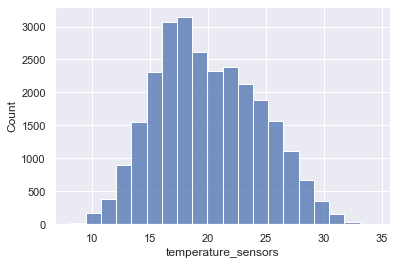

In [25]:
# Example of the distribution of measured temperatures in one day
sns.histplot(data=df[(df['timestamp'] > '2020-07-01') & (df['timestamp'] < '2020-07-15')], x='temperature_sensors', bins=20);

# Investigation of single locations

In [26]:
# group by location_id and calculate the total number of hours with measurements, date of the first and of the last measurement
location_grouped = df[(df['PM10'].notna()) & (df['PM2p5'].notna())][['location_id', 'timestamp']].\
    groupby(['location_id']).\
        agg(
                hours = pd.NamedAgg(column='timestamp', aggfunc='count'), 
                date_min = pd.NamedAgg(column='timestamp', aggfunc='min'),
                date_max = pd.NamedAgg(column='timestamp', aggfunc='max')
            ).\
            reset_index().\
                sort_values('hours', ascending=False)

location_grouped['date_min'] = pd.to_datetime(location_grouped['date_min'])
location_grouped['date_max'] = pd.to_datetime(location_grouped['date_max'])
location_grouped['period_length'] = location_grouped['date_max'] - location_grouped['date_min'] + pd.Timedelta(days=1)
location_grouped['hours_per_day'] = location_grouped['hours'] / location_grouped['period_length'].dt.days
location_grouped.head(5)

,location_id,hours,date_min,date_max,period_length,hours_per_day
97,98,18775,2020-01-01,2022-02-28 23:00:00,790 days 23:00:00,23.765823
32,33,18753,2020-01-01,2022-02-28 23:00:00,790 days 23:00:00,23.737975
11,12,18750,2020-01-01,2022-02-28 23:00:00,790 days 23:00:00,23.734177
98,99,18750,2020-01-01,2022-02-28 23:00:00,790 days 23:00:00,23.734177
102,103,18741,2020-01-01,2022-02-28 23:00:00,790 days 23:00:00,23.722785


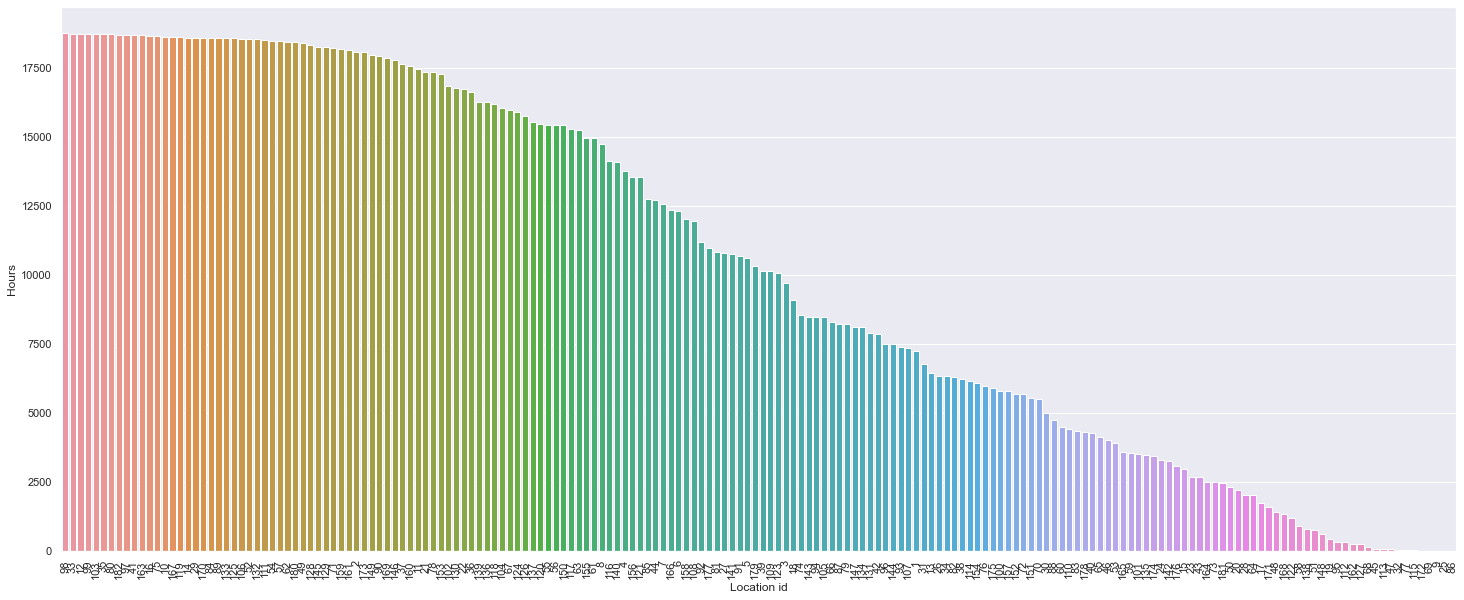

In [27]:
# plot the number of hours that were measured at each location
plt.figure(figsize=(25, 10))
g = sns.barplot(data=location_grouped, x='location_id', y='hours', order=location_grouped.sort_values('hours', ascending=False)['location_id'])
g.set_xlabel(g.get_xlabel().capitalize().replace('_', ' '))
g.set_ylabel(g.get_ylabel().capitalize())
plt.xticks(rotation=90);

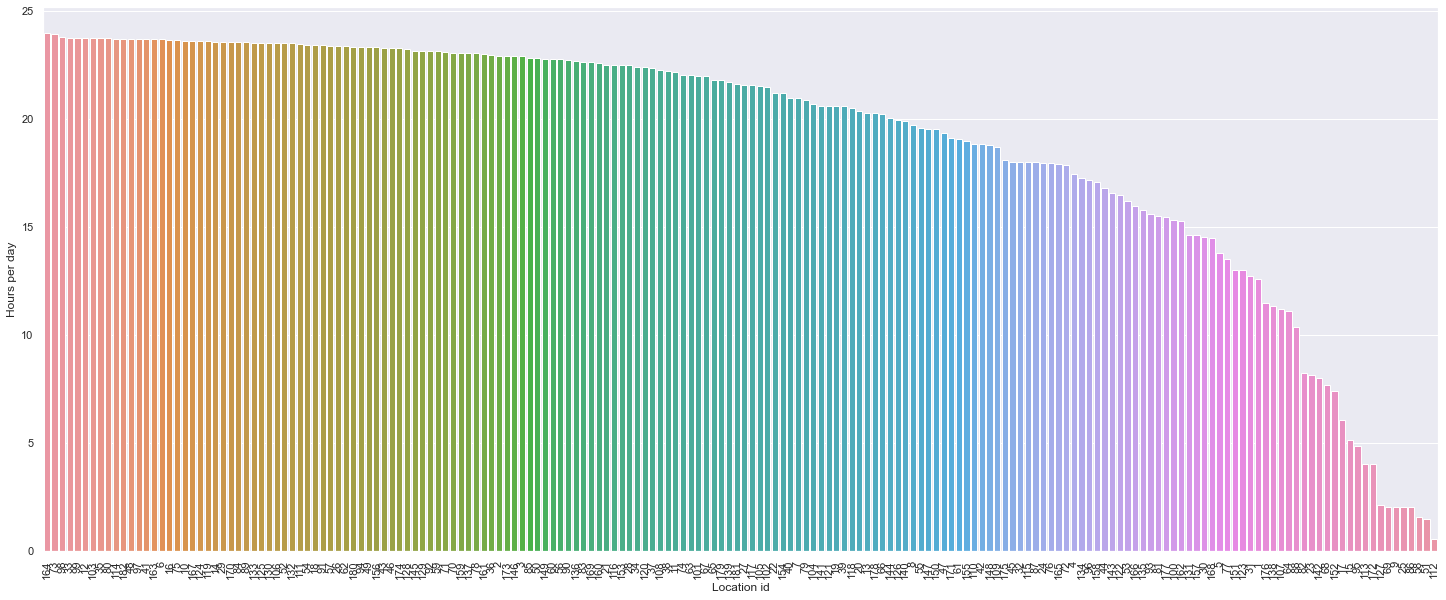

In [28]:
# plot the number of hours per day measured per location
plt.figure(figsize=(25, 10))
g = sns.barplot(data=location_grouped.sort_values('hours_per_day', ascending=False), x='location_id', y='hours_per_day', order=location_grouped.sort_values('hours_per_day', ascending=False)['location_id'])
g.set_xlabel(g.get_xlabel().capitalize().replace('_', ' '))
g.set_ylabel(g.get_ylabel().capitalize().replace('_', ' '))
plt.xticks(rotation=90);

In [29]:
print(f"Total number of locations: {location_grouped.shape[0]}")
print('Locations with the least hours of measurement:')
location_grouped.tail(20)

Total number of locations: 182
Locations with the least hours of measurement:


,location_id,hours,date_min,date_max,period_length,hours_per_day
137,138,803,2020-12-01 17:00:00,2021-02-09 23:00:00,71 days 06:00:00,11.309859
50,51,740,2020-04-04 14:00:00,2021-08-28 09:00:00,511 days 19:00:00,1.448141
147,148,620,2020-01-01 00:00:00,2020-02-02 21:00:00,33 days 21:00:00,18.787879
18,19,432,2021-12-17 14:00:00,2022-01-07 10:00:00,21 days 20:00:00,20.571429
94,95,314,2020-01-31 16:00:00,2020-04-05 14:00:00,65 days 22:00:00,4.830769
111,112,310,2020-06-13 19:00:00,2022-01-16 16:00:00,582 days 21:00:00,0.532646
161,162,229,2020-07-15 14:00:00,2020-07-29 22:00:00,15 days 08:00:00,15.266667
126,127,225,2020-01-01 10:00:00,2020-04-16 16:00:00,107 days 06:00:00,2.102804
67,68,130,2021-04-08 09:00:00,2021-04-24 09:00:00,17 days 00:00:00,7.647059
44,45,72,2021-09-29 16:00:00,2021-10-02 23:00:00,4 days 07:00:00,18.000000


In [30]:
location_grouped[['hours', 'hours_per_day']].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
hours,182.0,10287.9,6753.9,2.0,4033.2,10249.0,17547.0,18775.0
hours_per_day,182.0,19.0,5.9,0.5,17.2,21.6,23.2,24.0


There are some sensor locations which delivered data only for few hours

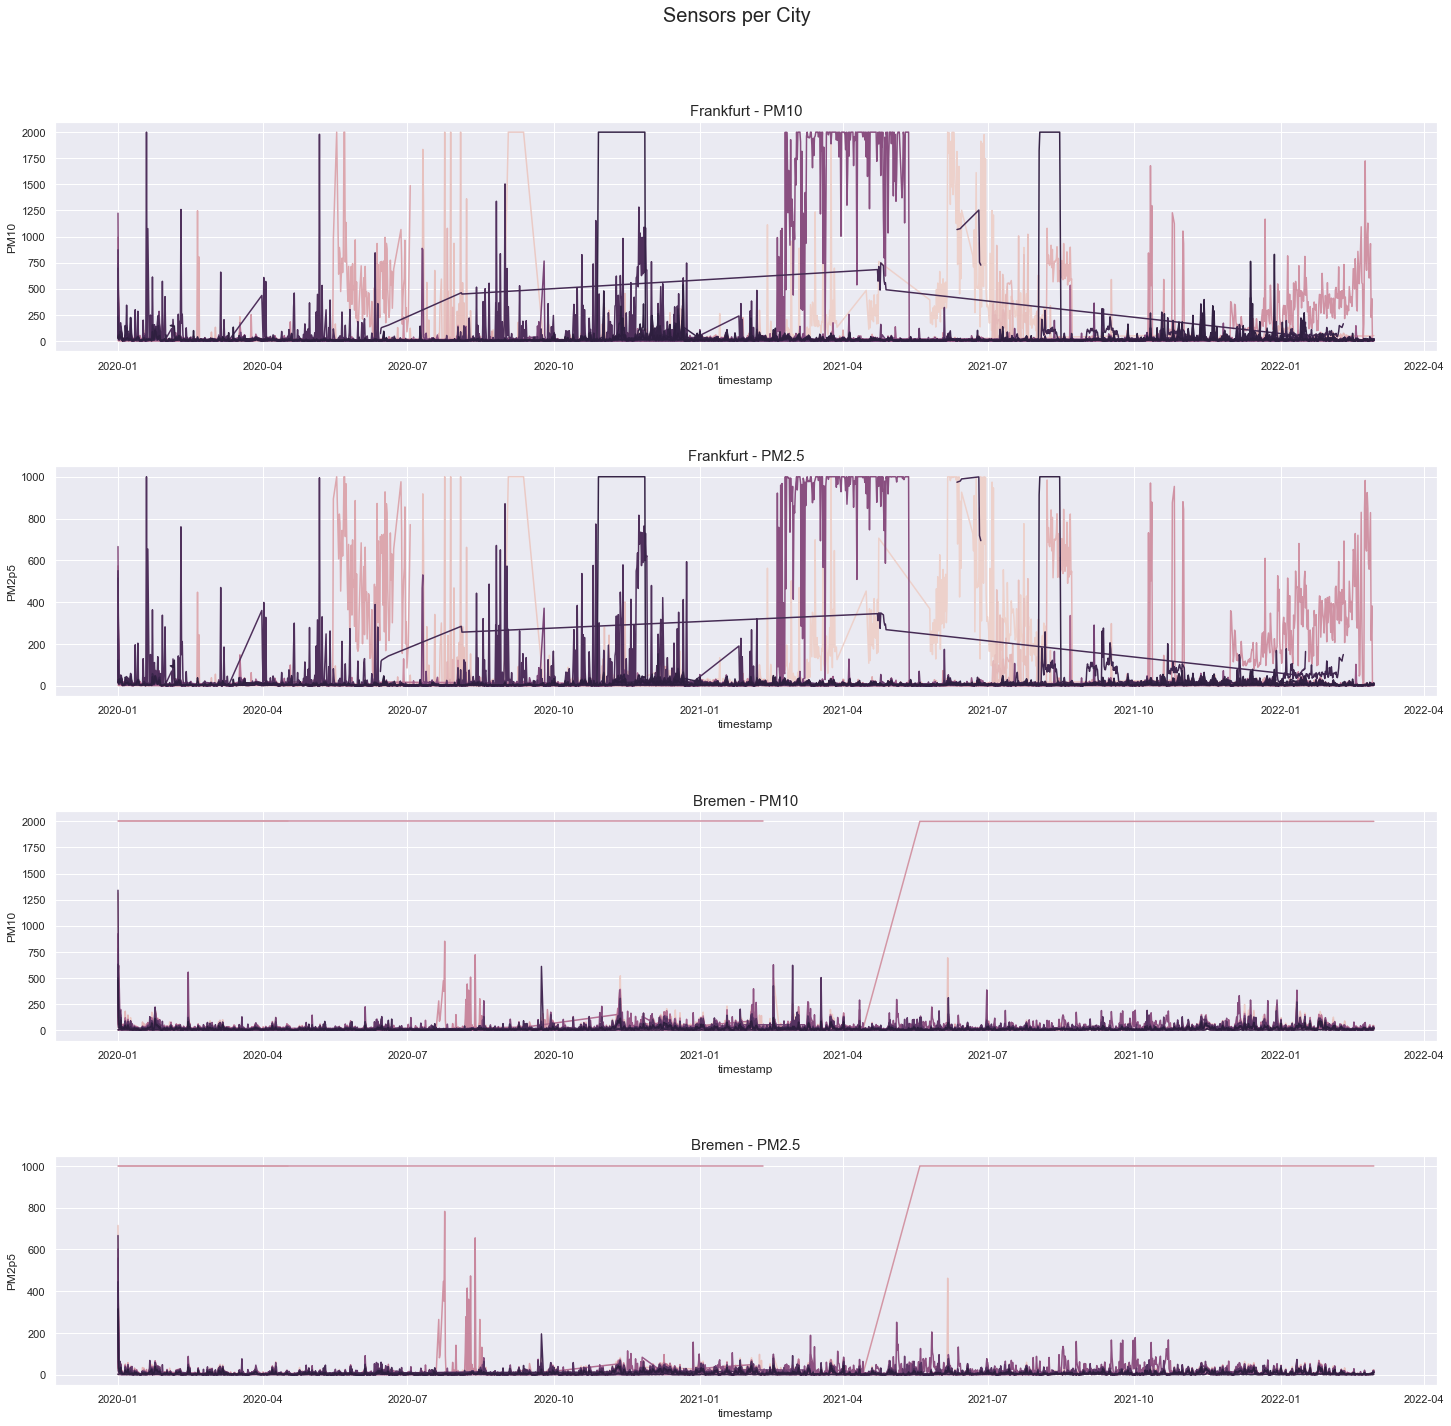

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 20))
plt.suptitle("Sensors per City", fontsize=20) # title of plot
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots

# get ids match them with the cities
labels_frankfurt = set(df.query("city=='Frankfurt'")['location_id'])
labels_bremen = set(df.query("city=='Bremen'")['location_id'])

# plot PM10 data of Frankfurt
sns.lineplot(data=df[df['city']=='Frankfurt'][::10], x='timestamp', y='PM10', hue='location_id', ax=ax1, legend=False)
ax1.legend(labels=labels_frankfurt) # assign a unique color to every id
ax1.set_title('Frankfurt - PM10', fontsize = 15) # set title and font size
ax1.legend([], [], frameon=False) # hide legend

# plot PM2.5 data for Frankfurt
sns.lineplot(data=df[df['city']=='Frankfurt'][::10], x='timestamp', y='PM2p5', hue='location_id', ax=ax2, legend=False)
ax2.legend(labels=labels_frankfurt)
ax2.set_title('Frankfurt - PM2.5', fontsize = 15)
ax2.legend([], [], frameon=False)

# plot PM10 data for Bremen
sns.lineplot(data=df[df['city']=='Bremen'][::10], x='timestamp', y='PM10', hue='location_id', ax=ax3, legend=False)
ax3.legend(labels=labels_bremen)
ax3.set_title('Bremen - PM10', fontsize = 15)
ax3.legend([], [], frameon=False)

# plot PM2.5 data for Bremen
sns.lineplot(data=df[df['city']=='Bremen'][::10], x='timestamp', y='PM2p5', hue='location_id', ax=ax4, legend=False)
ax4.legend(labels=labels_bremen)
ax4.set_title('Bremen - PM2.5', fontsize = 15)
ax4.legend([], [], frameon=False)


# Example location (location_id=2)

<AxesSubplot:xlabel='timestamp', ylabel='humidity_sensors'>

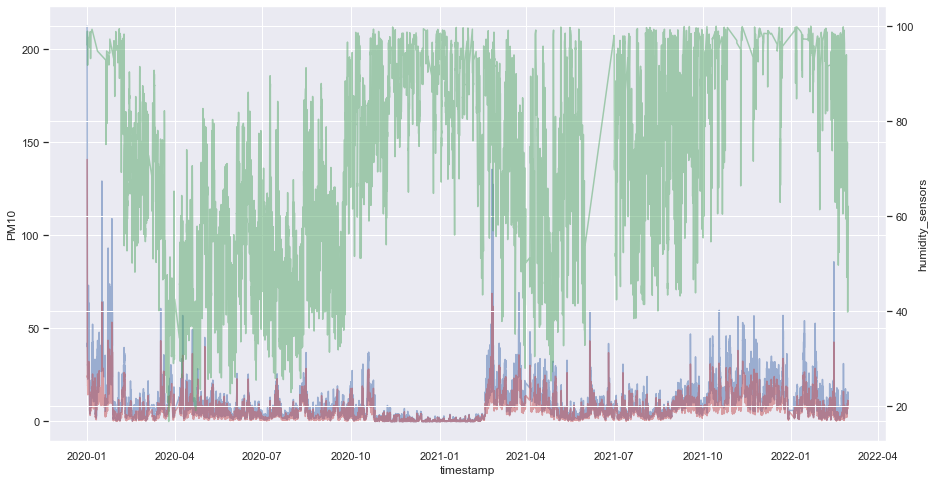

In [32]:
# get location_id's occuring in Frankfurt
ids_frankfurt = df.query("city=='Frankfurt'")['location_id'].unique()

# plot PM10, PM2.5 and humidity of one location
plt.figure(figsize=(15, 8))
ax = sns.lineplot(data=df[df['location_id']==ids_frankfurt[0]], x='timestamp', y='PM10', color='b', alpha=.5)
sns.lineplot(data=df[df['location_id']==ids_frankfurt[0]], x='timestamp', y='PM2p5', color="r", alpha=.5, ax=ax)
ax2 = ax.twinx() # add second y-axis
sns.lineplot(data=df[df['location_id']==ids_frankfurt[0]], x='timestamp', y='humidity_sensors', color="g", alpha=.5, ax=ax2)



<AxesSubplot:>

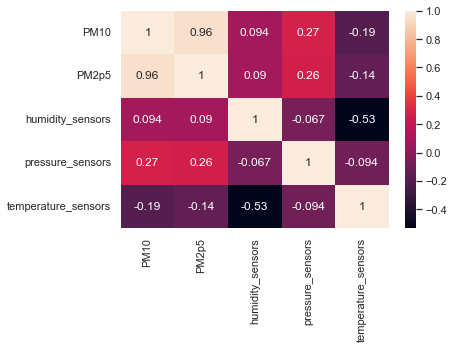

In [33]:
# Plot correlation heatmap for one single location
sns.heatmap(df[df['location_id']==ids_frankfurt[0]][sc_cols_wo_std].corr(), annot=True)

In [34]:
# make a dataframe containing timestamps of one year with resolution of one hour
one_year_full = pd.DataFrame()
one_year_full['timestamp'] = pd.date_range("2021-03-01", "2022-02-28 23:00:00", freq="H")

In [35]:
# add observations of one location to that dataframe
one_year_full_2 = pd.merge(one_year_full, df[df['location_id']==ids_frankfurt[0]], how='left', on='timestamp')
print(f"{one_year_full_2['PM10'].isna().sum()} missing values in PM10")
print(f"{one_year_full_2['PM2p5'].isna().sum()} missing values in PM2.5")

240 missing values in PM10
240 missing values in PM2.5


In [36]:
# get indices of observations where PM10 value is 'NaN'
missing_index = one_year_full_2.index[one_year_full_2['PM10'].isna()].tolist()

missing_periods = [] # list for periods of missing values
i = 0 # index for loop
start = None # start of a period
previous = None # index of the previous loop


while i < len(missing_index):
    # if start is None, it is the first loop
    if start == None:
        start = previous = missing_index[i]
        i += 1
        continue
    # if the current index is the previous index + 1, we are still moving within a closed period
    if missing_index[i] == previous+1:
        previous = missing_index[i]
        i += 1
        continue
    # else one period is over and another one is starting
    # add the closed period to the list of missing periods
    else:
        # print(start, previous)
        missing_periods.append(
            (one_year_full_2['timestamp'][start], 
            one_year_full_2['timestamp'][previous], 
            one_year_full_2['timestamp'][previous] - one_year_full_2['timestamp'][start] + pd.Timedelta(1, 'hour'))
        )
        start = previous = missing_index[i]
        i += 1
# add the last period to the list
missing_periods.append(
    (one_year_full_2['timestamp'][start], 
    one_year_full_2['timestamp'][previous], 
    one_year_full_2['timestamp'][previous]  - one_year_full_2['timestamp'][start] + pd.Timedelta(1, 'hour'))
)

# print the periods of missing PM10 values and their duration
p = 0
for start, end, duration in missing_periods:
    p += 1
    print(f"Period of missing values #{p}:\n\tstart: {start}\n\tend: {end}\n\tduration: {duration}\n")

Period of missing values #1:
	start: 2021-03-31 09:00:00
	end: 2021-04-04 08:00:00
	duration: 4 days 00:00:00

Period of missing values #2:
	start: 2021-07-06 18:00:00
	end: 2021-07-06 18:00:00
	duration: 0 days 01:00:00

Period of missing values #3:
	start: 2021-09-11 03:00:00
	end: 2021-09-11 03:00:00
	duration: 0 days 01:00:00

Period of missing values #4:
	start: 2021-11-16 00:00:00
	end: 2021-11-16 23:00:00
	duration: 1 days 00:00:00

Period of missing values #5:
	start: 2021-11-17 02:00:00
	end: 2021-11-17 05:00:00
	duration: 0 days 04:00:00

Period of missing values #6:
	start: 2021-12-29 20:00:00
	end: 2022-01-03 11:00:00
	duration: 4 days 16:00:00

Period of missing values #7:
	start: 2022-02-21 17:00:00
	end: 2022-02-21 18:00:00
	duration: 0 days 02:00:00



## Set dynamic thresholds

GOAL: Calculate a dynamic median over a certain period for all sensors in a city. If a value is for example twice the median it is estimated to be an error.

In [37]:
df

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,humidity_sensors,...,temperature_sensors,temperature_std,WRTR,humidity_dwd,precip,pressure_dwd,pressure_sealevel,temperature_dwd,wind_direction,wind_speed
0,2,2020-01-01 00:00:00,Frankfurt,50.042000,8.436000,212.110833,24.278724,140.574167,16.827501,96.000000,...,2.700000,NaN,NaN,90.0,0.0,1023.1,1036.5,0.0,40.0,2.7
1,2,2020-01-01 01:00:00,Frankfurt,50.042000,8.436000,196.873043,24.933247,129.469130,16.857172,96.100000,...,2.400000,NaN,0.0,90.0,0.0,1022.9,1036.3,0.1,20.0,2.8
2,2,2020-01-01 02:00:00,Frankfurt,50.042000,8.436000,188.258182,36.770146,124.460455,26.337616,96.633333,...,2.133333,0.057735,0.0,92.0,0.0,1022.8,1036.2,-1.1,70.0,2.2
3,2,2020-01-01 03:00:00,Frankfurt,50.042000,8.436000,166.444500,30.844667,105.790000,21.422815,97.600000,...,1.850000,0.057735,NaN,93.0,0.0,1022.3,1035.7,-0.4,80.0,1.6
4,2,2020-01-01 04:00:00,Frankfurt,50.042000,8.436000,101.033600,18.991551,62.073600,12.735376,97.550000,...,1.650000,0.212132,0.0,90.0,0.0,1022.1,1035.4,0.2,50.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450715,86,2022-02-28 19:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,46.0,0.0,1018.3,1031.4,5.3,80.0,1.3
3450716,86,2022-02-28 20:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,59.0,0.0,1018.5,1031.7,2.0,90.0,1.0
3450717,86,2022-02-28 21:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,61.0,0.0,1018.5,1031.7,1.8,50.0,2.0
3450718,86,2022-02-28 22:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,61.0,0.0,1018.3,1031.5,2.0,60.0,1.9


In [38]:
# # def calculate_threshold(df, t_start, t_end):
# #     print(t_start)

# df_cur = df[df['city'] == 'Frankfurt'][['location_id', 'timestamp', 'PM10', 'PM2p5']]

# t_min = df_cur['timestamp'].min()
# t_max = df_cur['timestamp'].max()

# df_cur['t_start'] = df_cur['timestamp'] - pd.Timedelta(5, 'h')
# df_cur.loc[(df_cur['t_start'] < t_min), 't_start'] = t_min

# df_cur['t_end'] = df_cur['timestamp'] + pd.Timedelta(5, 'h')
# df_cur.loc[(df_cur['t_end'] > t_max), 't_end'] = t_max

# # df_cur['threshold'] = df_cur.apply(lambda x: calculate_threshold(df_cur, x['t_start'], x['t_end']))
# # df_cur['PM10_threshold'] = df_cur.apply(lambda x: df_cur.loc[(df_cur['timestamp'] >= x['t_start']) & (df_cur['timestamp'] <= x['t_end'])]['PM10'].median(), axis=1)
# df_cur['PM10_threshold'] = df_cur.apply(lambda x: df_cur.loc[(df_cur['timestamp'] == x['timestamp'])]['PM10'].median(), axis=1)
# # df_cur['threshold'][:10] = 
# # df_cur[:5].apply(lambda x: print(x['t_start']), axis=1)

# df_cur

# df_test = df[(df['city'] == 'Frankfurt')]
# df_thresholds = pd.DataFrame(data={'timestamp': df_test['timestamp'].unique()})

# df_thresholds['PM10_threshold'] = df_thresholds.apply(lambda x: df_test[(df_test['timestamp'] == x['timestamp'])]['PM10'].median(), axis=1)


# df_thresholds


In [39]:
def clean_pm(df: pd.DataFrame, cols: list, factor: int = 3) -> pd.DataFrame:
    """deletes outliers for the given columns and considerung their timestamps and cities which are larger than factor times the median

    Args:
        df (pd.DataFrame): input dataframe
        cols (list): columns to clean
        factor (int, optional): factor that is used to calculate the threshold for keeping or deleting data. Defaults to 3.

    Returns:
        pd.DataFrame: cleaned dataframe
    """

    for col in df.columns:
        if 'threshold' in col:
            df.drop(col, axis=1, inplace=True)
    
    # define a list for saving the thresholds
    thresholds = []

    # for each city in the dataframe make a dataframe with timestamps
    for city in df['city'].unique():
        df_cur = df[df['city'] == city]
        df_threshold = pd.DataFrame(
            data={
                'timestamp': df_cur['timestamp'].unique(), 
                'city': city
            }
        )

        # for each timestamp calculate the median and threshold (factor * median)
        for col in cols:
            df_threshold[col+'_median'] = df_threshold.apply(lambda x: df_cur[(df_cur['timestamp'] == x['timestamp'])][col].median(), axis=1)
            df_threshold[col+'_threshold'] = factor * df_threshold[col+'_median']
        thresholds.append(df_threshold)

    df_thresholds = pd.DataFrame()
    for df_threshold in thresholds:
        df_thresholds = pd.concat([df_thresholds, df_threshold])

    df = df.merge(df_thresholds, how='left', on=['timestamp', 'city'])
    
    for col in cols:
        nan_before = df[col].isna().sum()
        df[col] = df.apply(lambda x: x[col] if x[col] <= x[col+'_threshold'] else np.nan, axis=1)
        print(f"{df[col].isna().sum() - nan_before} NaNs added in {col}")

    # for col in cols:
    #     df.drop([col+'_threshold'], axis=1, inplace=True)
    return df


nan_before_pm10 = df['PM10'].isna().sum()
nan_before_pm2p5 = df['PM2p5'].isna().sum()

df = clean_pm(df, ['PM10', 'PM2p5'])

print(f"{df['PM10'].isna().sum() - nan_before_pm10} NaNs added in PM10")
print(f"{df['PM2p5'].isna().sum() - nan_before_pm2p5} NaNs added in PM2p5")



47869 NaNs added in PM10
49951 NaNs added in PM2p5
47869 NaNs added in PM10
49951 NaNs added in PM2p5


In [40]:
df

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,humidity_sensors,...,precip,pressure_dwd,pressure_sealevel,temperature_dwd,wind_direction,wind_speed,PM10_median,PM10_threshold,PM2p5_median,PM2p5_threshold
0,2,2020-01-01 00:00:00,Frankfurt,50.042000,8.436000,212.110833,24.278724,140.574167,16.827501,96.000000,...,0.0,1023.1,1036.5,0.0,40.0,2.7,433.292292,1299.876875,241.772228,725.316683
1,2,2020-01-01 01:00:00,Frankfurt,50.042000,8.436000,196.873043,24.933247,129.469130,16.857172,96.100000,...,0.0,1022.9,1036.3,0.1,20.0,2.8,286.935200,860.805600,151.105000,453.315000
2,2,2020-01-01 02:00:00,Frankfurt,50.042000,8.436000,188.258182,36.770146,124.460455,26.337616,96.633333,...,0.0,1022.8,1036.2,-1.1,70.0,2.2,182.878125,548.634375,91.174182,273.522545
3,2,2020-01-01 03:00:00,Frankfurt,50.042000,8.436000,166.444500,30.844667,105.790000,21.422815,97.600000,...,0.0,1022.3,1035.7,-0.4,80.0,1.6,145.721667,437.165000,79.951200,239.853600
4,2,2020-01-01 04:00:00,Frankfurt,50.042000,8.436000,101.033600,18.991551,62.073600,12.735376,97.550000,...,0.0,1022.1,1035.4,0.2,50.0,2.0,100.915342,302.746025,52.900587,158.701761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450715,86,2022-02-28 19:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,0.0,1018.3,1031.4,5.3,80.0,1.3,14.259583,42.778750,7.392500,22.177500
3450716,86,2022-02-28 20:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,0.0,1018.5,1031.7,2.0,90.0,1.0,14.603258,43.809775,7.598958,22.796875
3450717,86,2022-02-28 21:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,0.0,1018.5,1031.7,1.8,50.0,2.0,14.543478,43.630435,7.971667,23.915000
3450718,86,2022-02-28 22:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,0.0,1018.3,1031.5,2.0,60.0,1.9,13.395000,40.185000,7.651250,22.953750


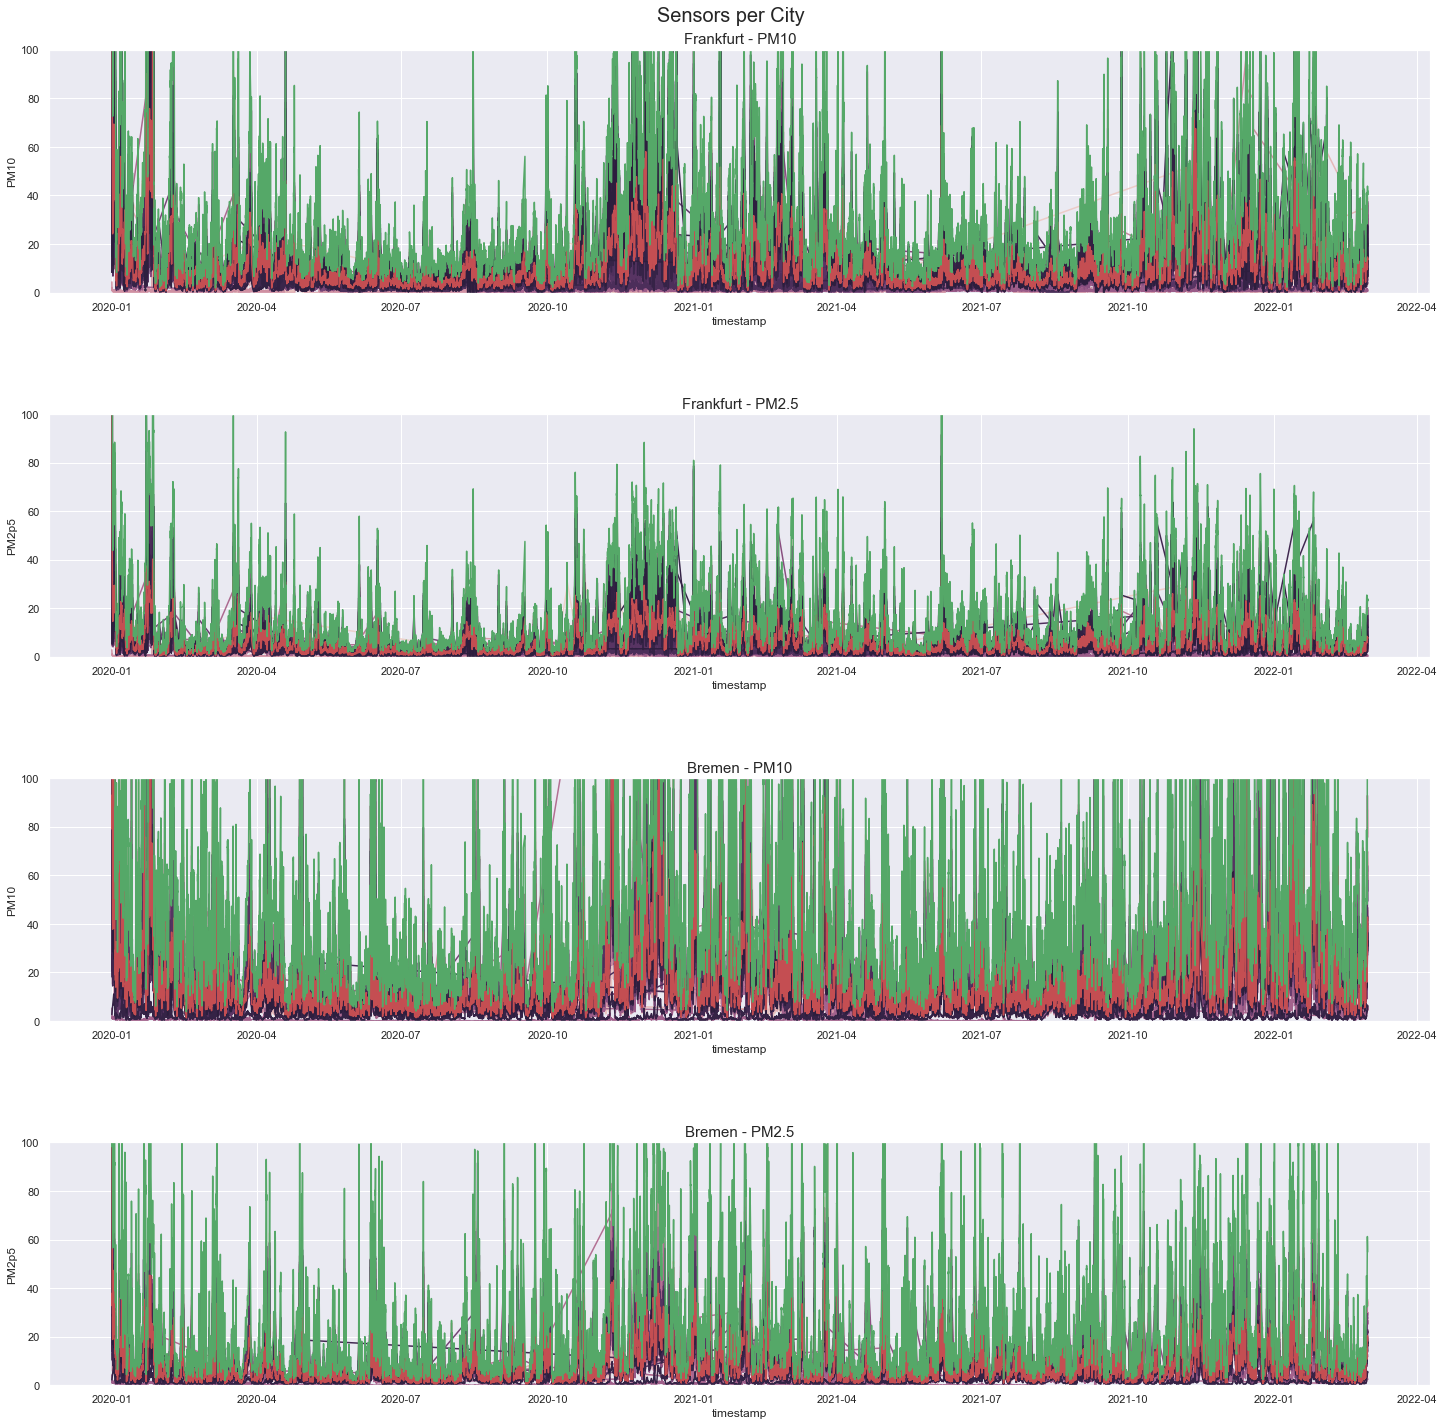

In [59]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 20))
plt.suptitle("Sensors per City", fontsize=20) # title of plot
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .95) # adjusts the space between the single subplots

# get ids match them with the cities
labels_frankfurt = set(df.query("city=='Frankfurt'")['location_id'])
labels_bremen = set(df.query("city=='Bremen'")['location_id'])

# plot PM10 data of Frankfurt
sns.lineplot(data=df[df['city']=='Frankfurt'], x='timestamp', y='PM10', hue='location_id', ax=ax1, legend=False)
# sns.lineplot(data=df[df['city']=='Frankfurt'][['timestamp', 'PM10_median']].groupby('timestamp').mean(), x='timestamp', y='PM10_median', ax=ax1, legend=False, color='r')
# sns.lineplot(data=df[df['city']=='Frankfurt'][['timestamp', 'PM10_threshold']].groupby('timestamp').mean(), x='timestamp', y='PM10_threshold', ax=ax1, legend=False, color='g')
ax1.legend(labels=labels_frankfurt) # assign a unique color to every id
ax1.set_title('Frankfurt - PM10', fontsize = 15) # set title and font size
ax1.legend([], [], frameon=False) # hide legend

# plot PM2.5 data for Frankfurt
sns.lineplot(data=df[df['city']=='Frankfurt'], x='timestamp', y='PM2p5', hue='location_id', ax=ax2, legend=False)
# sns.lineplot(data=df[df['city']=='Frankfurt'][['timestamp', 'PM2p5_median']].groupby('timestamp').mean(), x='timestamp', y='PM2p5_median', ax=ax2, legend=False, color='r')
# sns.lineplot(data=df[df['city']=='Frankfurt'][['timestamp', 'PM2p5_threshold']].groupby('timestamp').mean(), x='timestamp', y='PM2p5_threshold', ax=ax2, legend=False, color='g')
ax2.legend(labels=labels_frankfurt)
ax2.set_title('Frankfurt - PM2.5', fontsize = 15)
ax2.legend([], [], frameon=False)

# plot PM10 data for Bremen
sns.lineplot(data=df[df['city']=='Bremen'], x='timestamp', y='PM10', hue='location_id', ax=ax3, legend=False)
# sns.lineplot(data=df[df['city']=='Bremen'][['timestamp', 'PM10_median']].groupby('timestamp').mean(), x='timestamp', y='PM10_median', ax=ax3, legend=False, color='r')
# sns.lineplot(data=df[df['city']=='Bremen'][['timestamp', 'PM10_threshold']].groupby('timestamp').mean(), x='timestamp', y='PM10_threshold', ax=ax3, legend=False, color='g')
ax3.legend(labels=labels_bremen)
ax3.set_title('Bremen - PM10', fontsize = 15)
ax3.legend([], [], frameon=False)

# plot PM2.5 data for Bremen
sns.lineplot(data=df[df['city']=='Bremen'], x='timestamp', y='PM2p5', hue='location_id', ax=ax4, legend=False)
# sns.lineplot(data=df[df['city']=='Bremen'][['timestamp', 'PM2p5_median']].groupby('timestamp').mean(), x='timestamp', y='PM2p5_median', ax=ax4, legend=False, color='r')
# sns.lineplot(data=df[df['city']=='Bremen'][['timestamp', 'PM2p5_threshold']].groupby('timestamp').mean(), x='timestamp', y='PM2p5_threshold', ax=ax4, legend=False, color='g')
ax4.legend(labels=labels_bremen)
ax4.set_title('Bremen - PM2.5', fontsize = 15)
ax4.legend([], [], frameon=False)

# for axis in [ax1, ax2, ax3, ax4]:
#     axis.set_ylim(0, 100)

In [42]:
df.head()

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,humidity_sensors,...,precip,pressure_dwd,pressure_sealevel,temperature_dwd,wind_direction,wind_speed,PM10_median,PM10_threshold,PM2p5_median,PM2p5_threshold
0,2,2020-01-01 00:00:00,Frankfurt,50.042,8.436,212.110833,24.278724,140.574167,16.827501,96.000000,...,0.0,1023.1,1036.5,0.0,40.0,2.7,433.292292,1299.876875,241.772228,725.316683
1,2,2020-01-01 01:00:00,Frankfurt,50.042,8.436,196.873043,24.933247,129.469130,16.857172,96.100000,...,0.0,1022.9,1036.3,0.1,20.0,2.8,286.935200,860.805600,151.105000,453.315000
2,2,2020-01-01 02:00:00,Frankfurt,50.042,8.436,188.258182,36.770146,124.460455,26.337616,96.633333,...,0.0,1022.8,1036.2,-1.1,70.0,2.2,182.878125,548.634375,91.174182,273.522545
3,2,2020-01-01 03:00:00,Frankfurt,50.042,8.436,166.444500,30.844667,105.790000,21.422815,97.600000,...,0.0,1022.3,1035.7,-0.4,80.0,1.6,145.721667,437.165000,79.951200,239.853600
4,2,2020-01-01 04:00:00,Frankfurt,50.042,8.436,101.033600,18.991551,62.073600,12.735376,97.550000,...,0.0,1022.1,1035.4,0.2,50.0,2.0,100.915342,302.746025,52.900587,158.701761


In [43]:
# make dataframe containing the timestamps
df_missing_values_bremen_pm10 = pd.DataFrame(
    data={
        'timestamp': df['timestamp'].unique(),
    }
)

# copy that dataframe for every combination of PM sensor and city
df_missing_values_bremen_pm2p5 = df_missing_values_bremen_pm10.copy()
df_missing_values_frankfurt_pm10 = df_missing_values_bremen_pm10.copy()
df_missing_values_frankfurt_pm2p5 = df_missing_values_bremen_pm10.copy()

# add sensor data for every location in Bremen
for location in df.loc[df['city'] == 'Bremen', 'location_id'].unique():
    df_missing_values_bremen_pm10 = pd.merge(df_missing_values_bremen_pm10, df.loc[df['location_id']==location, ['timestamp','PM10']], on='timestamp')
    df_missing_values_bremen_pm10.rename(columns={'PM10': location}, inplace=True) # rename the new column using the location_id
    df_missing_values_bremen_pm10.set_index('timestamp', inplace=True) # use timestamps as index

    df_missing_values_bremen_pm2p5 = pd.merge(df_missing_values_bremen_pm2p5, df.loc[df['location_id']==location, ['timestamp','PM2p5']], on='timestamp')
    df_missing_values_bremen_pm2p5.rename(columns={'PM2p5': location}, inplace=True)
    df_missing_values_bremen_pm2p5.set_index('timestamp', inplace=True)

# do the same for Frankfurt
for location in df.loc[df['city'] == 'Frankfurt', 'location_id'].unique():
    df_missing_values_frankfurt_pm10 = pd.merge(df_missing_values_frankfurt_pm10, df.loc[df['location_id']==location, ['timestamp','PM10']], on='timestamp')
    df_missing_values_frankfurt_pm10.rename(columns={'PM10': location}, inplace=True)
    df_missing_values_frankfurt_pm10.set_index('timestamp', inplace=True)

    df_missing_values_frankfurt_pm2p5 = pd.merge(df_missing_values_frankfurt_pm2p5, df.loc[df['location_id']==location, ['timestamp','PM2p5']], on='timestamp')
    df_missing_values_frankfurt_pm2p5.rename(columns={'PM2p5': location}, inplace=True)
    df_missing_values_frankfurt_pm2p5.set_index('timestamp', inplace=True)



,2,3,6,7,10,11,12,13,14,16,...,43,20,73,19,48,113,9,25,69,86
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,140.574167,311.089200,203.632500,86.575000,51.565833,148.212000,124.803200,218.007083,281.740000,326.6925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,129.469130,338.862174,200.834400,112.191667,80.973750,92.340833,83.337273,177.156400,168.595455,286.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,124.460455,NaN,168.026957,86.916667,60.555833,NaN,63.907826,240.288261,106.498000,229.7275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,105.790000,223.100000,126.696087,67.388889,47.871667,82.083043,74.890000,140.887917,74.549545,193.4325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,62.073600,NaN,79.596400,43.950000,29.797500,39.792500,33.797826,70.383200,43.099130,107.8500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28 19:00:00,11.383200,NaN,NaN,NaN,4.063878,8.781200,5.544082,NaN,10.126667,6.2575,...,9.758333,8.944800,7.154583,NaN,18.0944,NaN,NaN,NaN,NaN,NaN
2022-02-28 20:00:00,10.412083,NaN,NaN,NaN,3.811250,10.150000,5.266250,NaN,15.078696,7.7900,...,10.711600,8.302083,7.396800,NaN,19.8200,NaN,NaN,NaN,NaN,NaN
2022-02-28 21:00:00,9.604167,NaN,NaN,NaN,3.982917,8.539200,4.551400,NaN,5.990000,6.8000,...,10.852800,9.568333,7.392000,NaN,20.4004,NaN,NaN,NaN,NaN,NaN


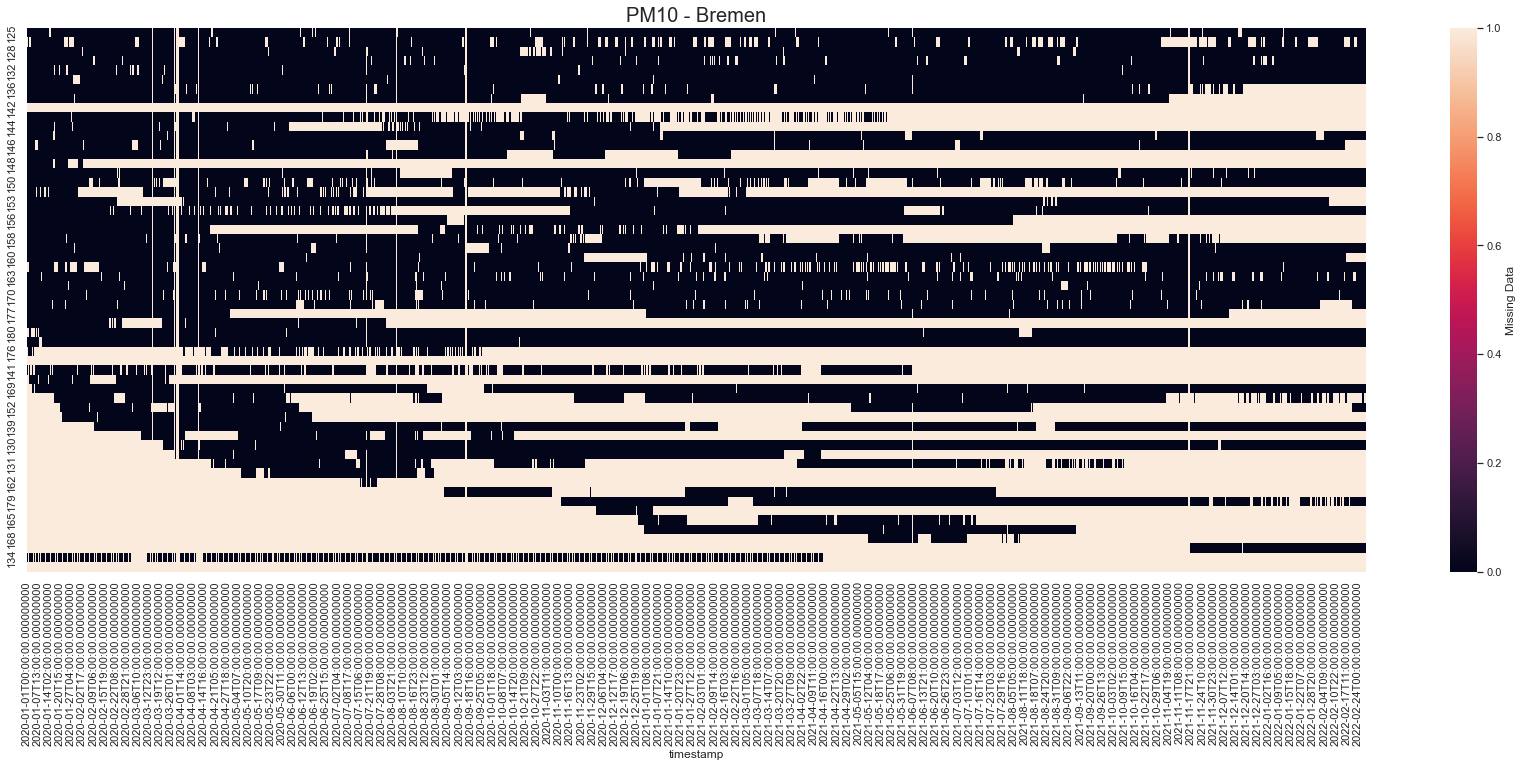

In [45]:
# plot missing values per id for PM10 in Bremen
plt.figure(figsize=(30, 10))
g = sns.heatmap(df_missing_values_bremen_pm10.isna().T, cbar_kws={'label': 'Missing Data'})
g.set_title('PM10 - Bremen', fontsize=20);

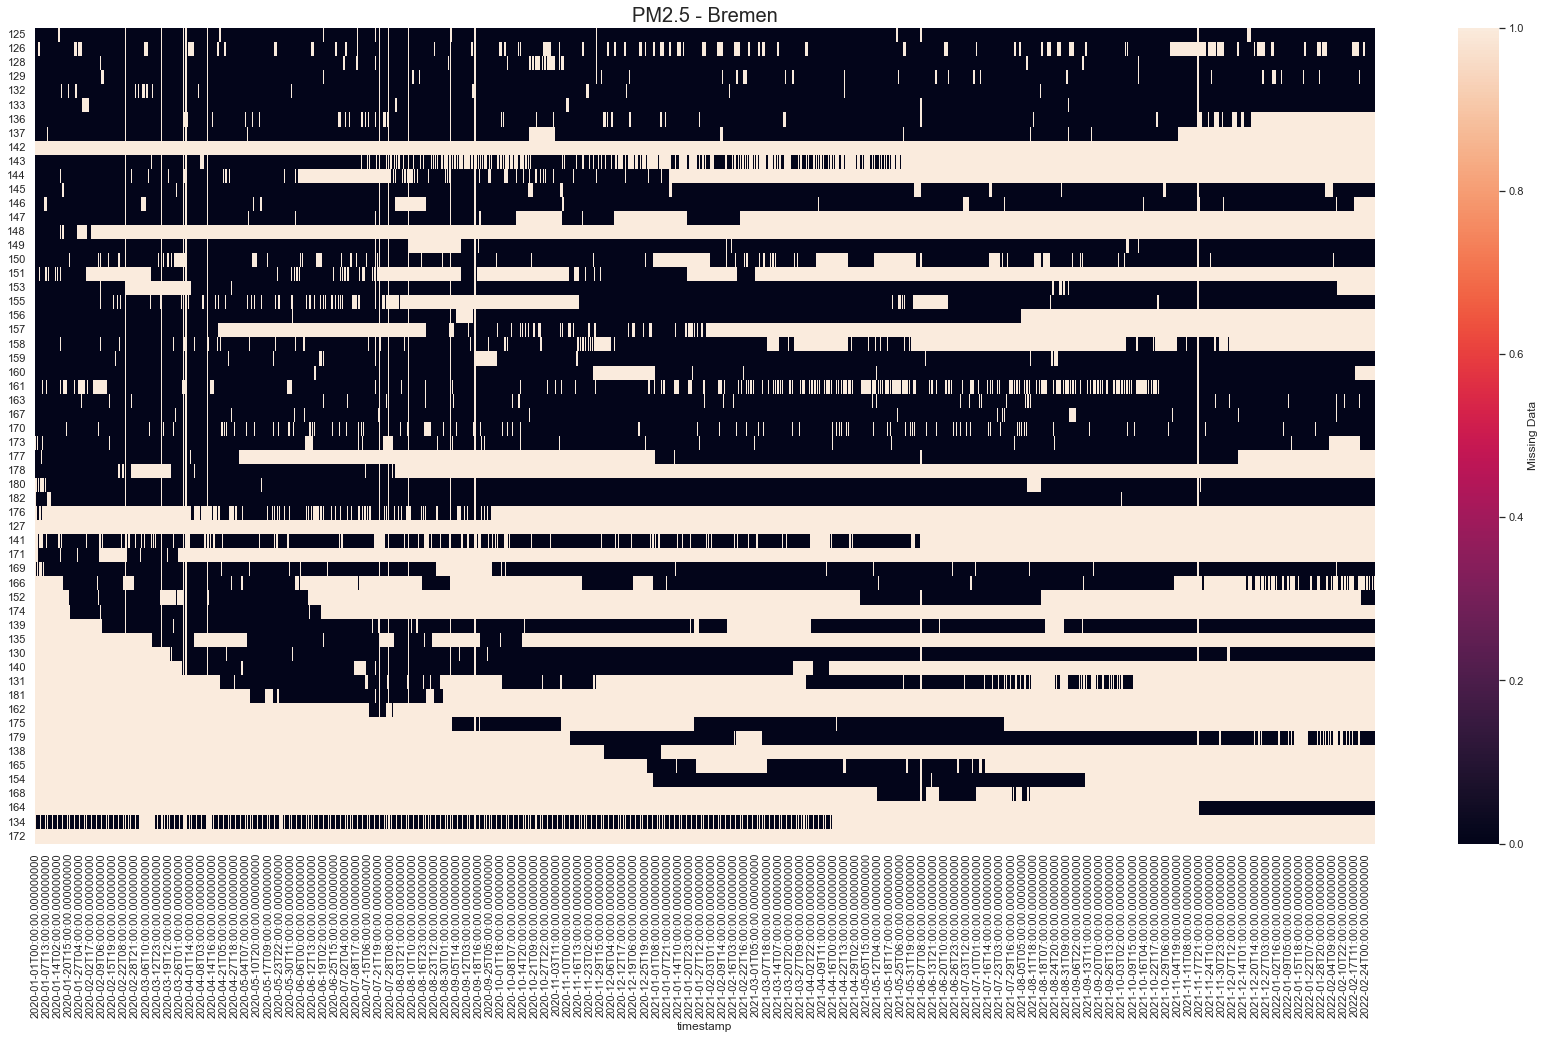

In [46]:
# plot missing values per id for PM2.5 in Bremen
plt.figure(figsize=(30, 15))
g = sns.heatmap(df_missing_values_bremen_pm2p5.isna().T, cbar_kws={'label': 'Missing Data'})
g.set_title('PM2.5 - Bremen', fontsize=20);

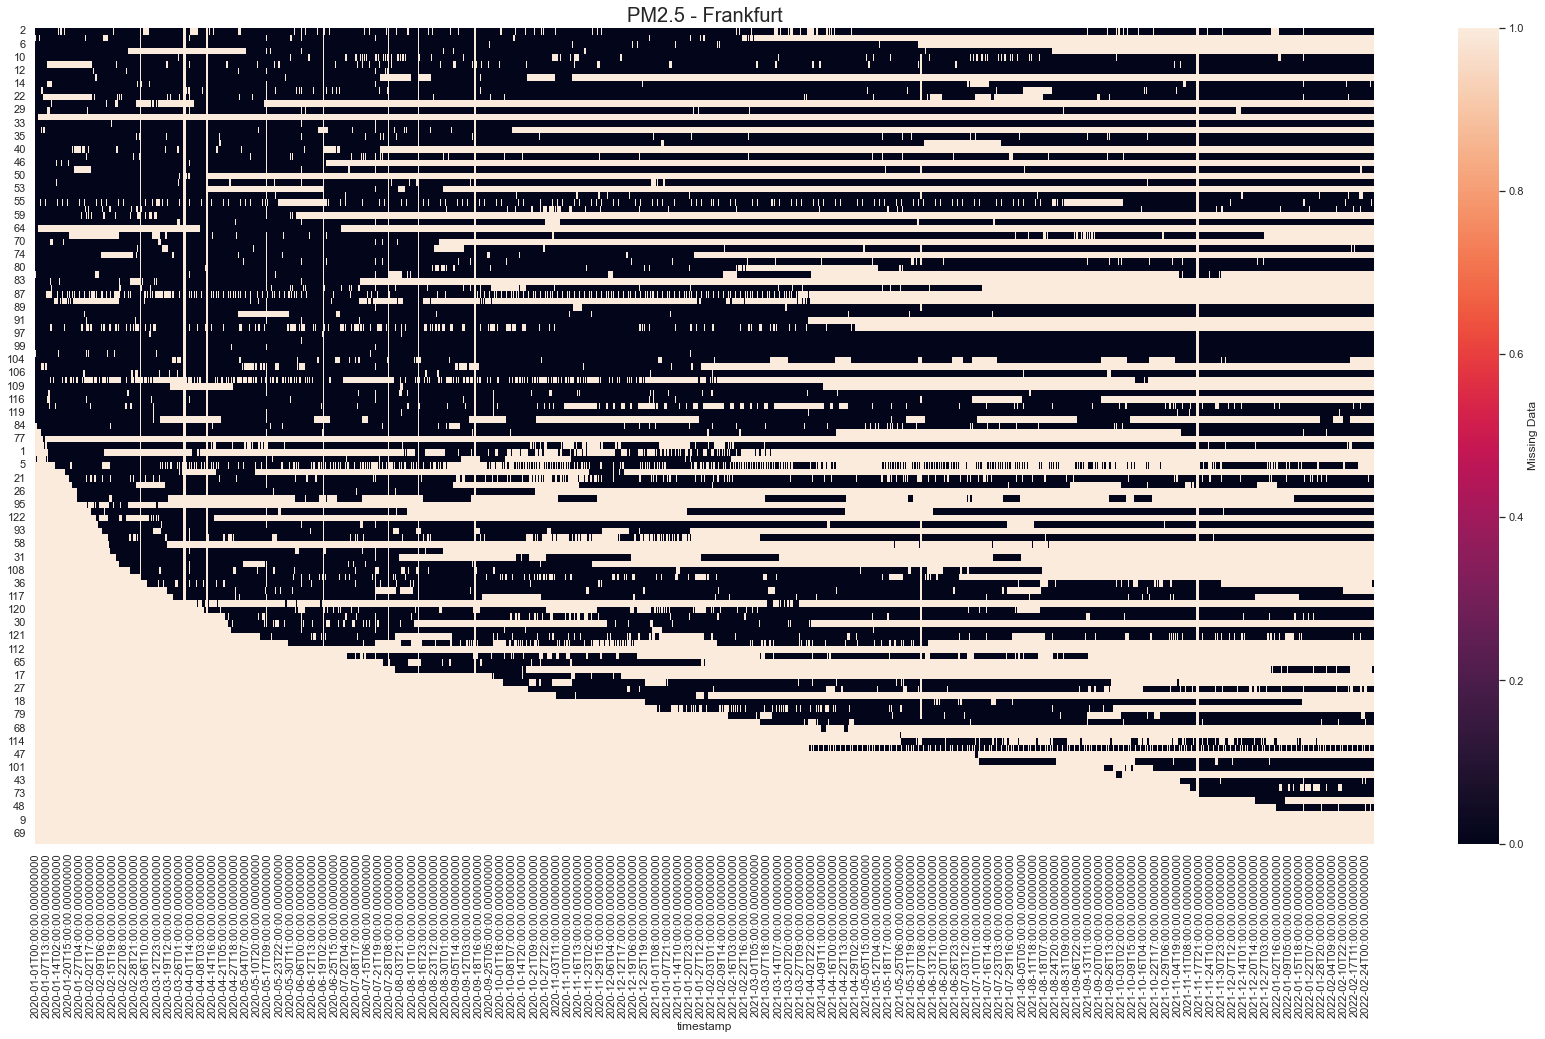

In [47]:
# plot missing values per id for PM2.5 in Frankfurt
plt.figure(figsize=(30, 15))
g = sns.heatmap(df_missing_values_frankfurt_pm2p5.isna().T, cbar_kws={'label': 'Missing Data'})
g.set_title('PM2.5 - Frankfurt', fontsize=20);

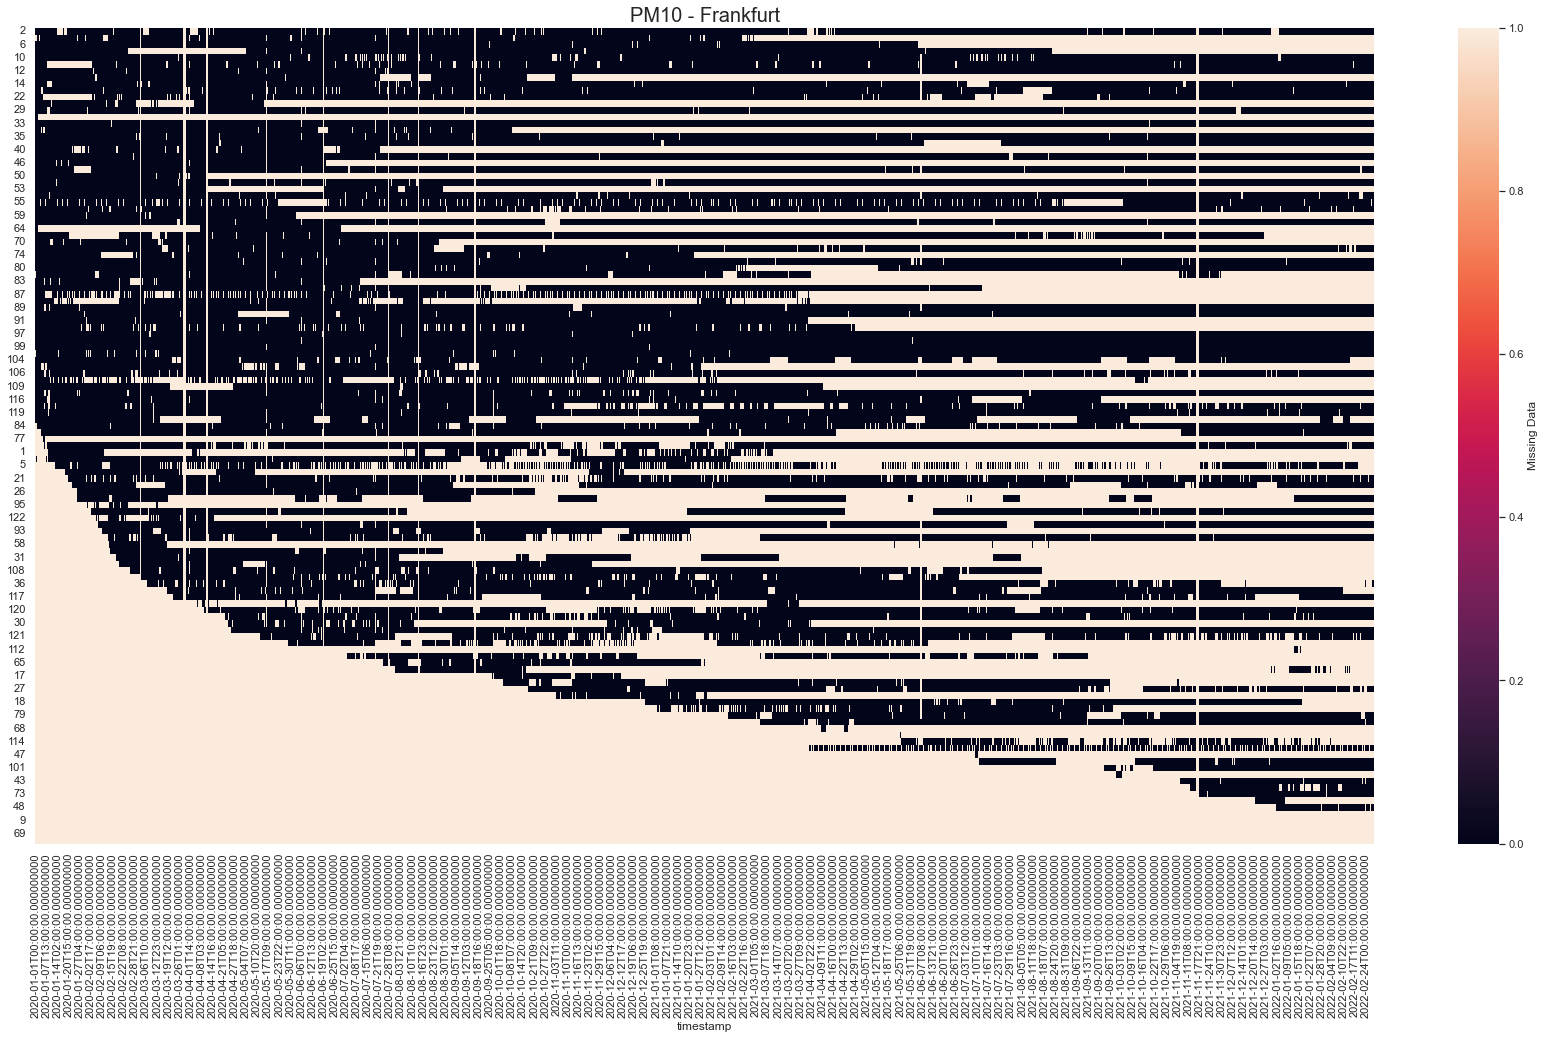

In [48]:
# plot missing values per id for PM10 in Frankfurt
plt.figure(figsize=(30, 15))
g = sns.heatmap(df_missing_values_frankfurt_pm10.isna().T, cbar_kws={'label': 'Missing Data'})
g.set_title('PM10 - Frankfurt', fontsize=20);